<a href="https://colab.research.google.com/github/esemlak/esemlak/blob/main/billiard_csv_tensorflow_model_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!unzip -o /content/colab_train_big.zip
!pip3 install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
DATASET_PATH = "/content/colab_train_big.csv"


# "r" for regression and "c" for classification
# for classification, the number of output nodes is automatically determined
TASK = "r"

# don't change the dummy batch size. There is a small bug in tensorflow.
# to get around that bug, dummy batch size is used
DUMMY_BATCH_SIZE = 5
BATCH_SIZE = 100
EPOCHS = 100
TRAIN_FRAC = 0.8

CHECKPOINT_DIR = "/content/"

In [3]:
from collections import defaultdict
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import kerastuner as kt

import IPython

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


# This function will give us a fresh dataset object

In [4]:
def get_dataset(batch_size = 5):
    return tf.data.experimental.make_csv_dataset(
        DATASET_PATH,
        batch_size = batch_size,
        num_epochs = 1,
        field_delim= ';',
        header = True,
        label_name = "SCORE"
    )

# Creating the Model Inputs as a dictionary

In [5]:
model_inputs = {}
model_outputs = {}

for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
    for col_name, col_values in batch.items():
        if (col_name == 'X1' or col_name == 'X2' or col_name == 'X3' or col_name == 'X4' or col_name == 'Y1' or col_name == 'Y2' or col_name == 'Y3' or col_name == 'Y4'):
          model_inputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=col_values.dtype)
        if (col_name == 'VX' or col_name == 'VY'):
          model_outputs[col_name] = tf.keras.Input(shape=(1,), name=col_name, dtype=col_values.dtype)

In [6]:
model_inputs

{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>}

In [7]:
model_outputs

{'VX': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VX')>,
 'VY': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VY')>}

## split these inputs into their own dictionaries based on the data type

In [8]:
float_inputs = {}

for col_name, col_input in model_inputs.items():
    float_inputs[col_name] = col_input
    
float_outputs = {}

for col_name, col_input in model_outputs.items():
    float_outputs[col_name] = col_input


In [9]:
float_inputs


{'X1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X1')>,
 'Y1': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y1')>,
 'X2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X2')>,
 'Y2': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y2')>,
 'X3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X3')>,
 'Y3': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y3')>,
 'X4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'X4')>,
 'Y4': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Y4')>}

In [10]:
float_outputs

{'VX': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VX')>,
 'VY': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'VY')>}

In [11]:
def numerical_input_processor(inputs):
    if not inputs:
        return
    
    concat = None
    if len(inputs.values()) > 1:
        concat = tf.keras.layers.Concatenate()(list(inputs.values()))
    
    norm = tf.keras.layers.experimental.preprocessing.Normalization()

    for batch, _ in get_dataset(batch_size=DUMMY_BATCH_SIZE).take(1):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)    

        norm.adapt(data)

    # mean_log = []

    for batch, _ in get_dataset(batch_size=BATCH_SIZE):
        data = []
        
        for k in inputs.keys():
            data.append(np.array(batch[k]))    
        
        data = np.array(data)
        data = np.transpose(data)

        norm.adapt(data)        
        # mean_log.append(norm.mean.numpy())    

    if concat is not None:
        numeric_layer = norm(concat)
    else:
        numeric_layer = norm(list(inputs.values())[0])
    
    return numeric_layer

## PreProcess the inputs

In [12]:
float_layer = numerical_input_processor(float_inputs)
output_layer = numerical_input_processor(float_outputs)

In [13]:
float_layer

<KerasTensor: shape=(None, 8) dtype=float32 (created by layer 'normalization')>

In [14]:
output_layer

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'normalization_1')>

## Create a preprocessing keras model

In [15]:
preprocessing_head = tf.keras.Model(model_inputs, output_layer)

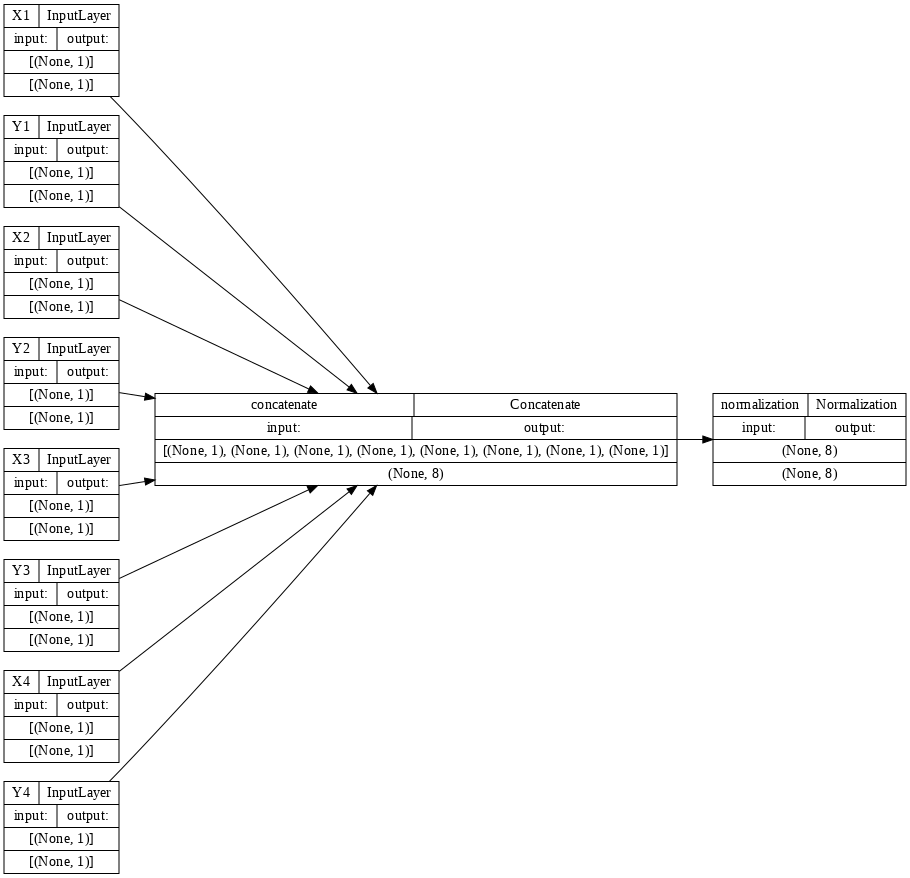

In [16]:
tf.keras.utils.plot_model(model = preprocessing_head, rankdir="LR", dpi=72, show_shapes=True, expand_nested=True, to_file="preprocessing_head.png")

## You can also see the preprocessed outputs for the given inputs

In [17]:
# preprocessing_head({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

# preprocessing_head({
#     "age" : np.array([22.0]),
#     "fare" : np.array([7.25]),
# })

## pass the model_inputs through the preprocessing_head

In [18]:
preprocessed_outputs = preprocessing_head(model_inputs)

In [19]:
num_preprocessed_outputs = list(preprocessed_outputs.shape)[-1]

In [20]:
num_preprocessed_outputs

8

## Find out how many batches should be used for training and how many for validation

In [21]:
dataset_size = 0

for _ in get_dataset(batch_size=BATCH_SIZE):
    dataset_size += 1

In [22]:
train_size = int(TRAIN_FRAC * dataset_size)

In [23]:
print(dataset_size)
print(train_size)

296
236


## Split the training and validation datasets


In [24]:
dataset = get_dataset(batch_size=BATCH_SIZE)

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

## Set a caching mechanism that prefetches the next batch while the current batch is training

In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## define early stopping and checkpointing callbacks

In [26]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CHECKPOINT_DIR, "M.{epoch:02d}-{val_loss:.2f}"))

In [27]:
callbacks = [
    early_stopping_callback,
    checkpoint_callback,
]

In [28]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

## model builder function is used by keras-tuner to find the best parameters for a model

In [29]:
def model_builder(hp):
    loss_fn = {'xv_output': 'mse', 'yv_output': 'mse'}

    metrics={'xv_output':tf.keras.metrics.RootMeanSquaredError(), 'yv_output':tf.keras.metrics.RootMeanSquaredError()}
 
    kernel_hp = hp.Choice('kernel_regularization', values = [0.01, 0.001, 0.0001, 0.00001])
    activation_hp = hp.Choice("activation", values=["elu", "relu"])
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.01,
        decay_steps=train_size*1000,
        decay_rate=1,
        staircase=False
    )


    input_layer = tf.keras.layers.Input(shape=8)

    first_dense = tf.keras.layers.Dense(units='8', activation='relu')(preprocessed_outputs )
    
    #XV output will be fed from the first dense
    xv_output = tf.keras.layers.Dense(units='1', name='xv_output')(first_dense)
    
    second_dense = tf.keras.layers.Dense(units='8',activation='relu')(first_dense)
    
    #YV output will be fed from the second dense
    yv_output = tf.keras.layers.Dense(units='1',name='yv_output')(second_dense)

    
    model = tf.keras.Model(model_inputs, outputs = [xv_output, yv_output])
    
    model.compile(loss=loss_fn, 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
                  metrics=metrics
    )
  
    return model



## initialize keras tuner

In [30]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'tuner_dir',
                     project_name = 'tuner')

In [31]:
tuner.search(
    train_dataset, 
    validation_data=val_dataset,
    epochs=10,
    callbacks = [ClearTrainingOutput()]
)

In [32]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

## These are the best model parameters

In [33]:
best_hps.values

{'kernel_regularization': 0.01,
 'activation': 'elu',
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 2,
 'tuner/round': 0}

In [34]:
model = tuner.hypermodel.build(best_hps)

In [35]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X1 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X2 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X3 (InputLayer)                [(None, 1)]          0           []                               
                                                                                                  
 X4 (InputLayer)                [(None, 1)]          0           []                               
                                                                                            

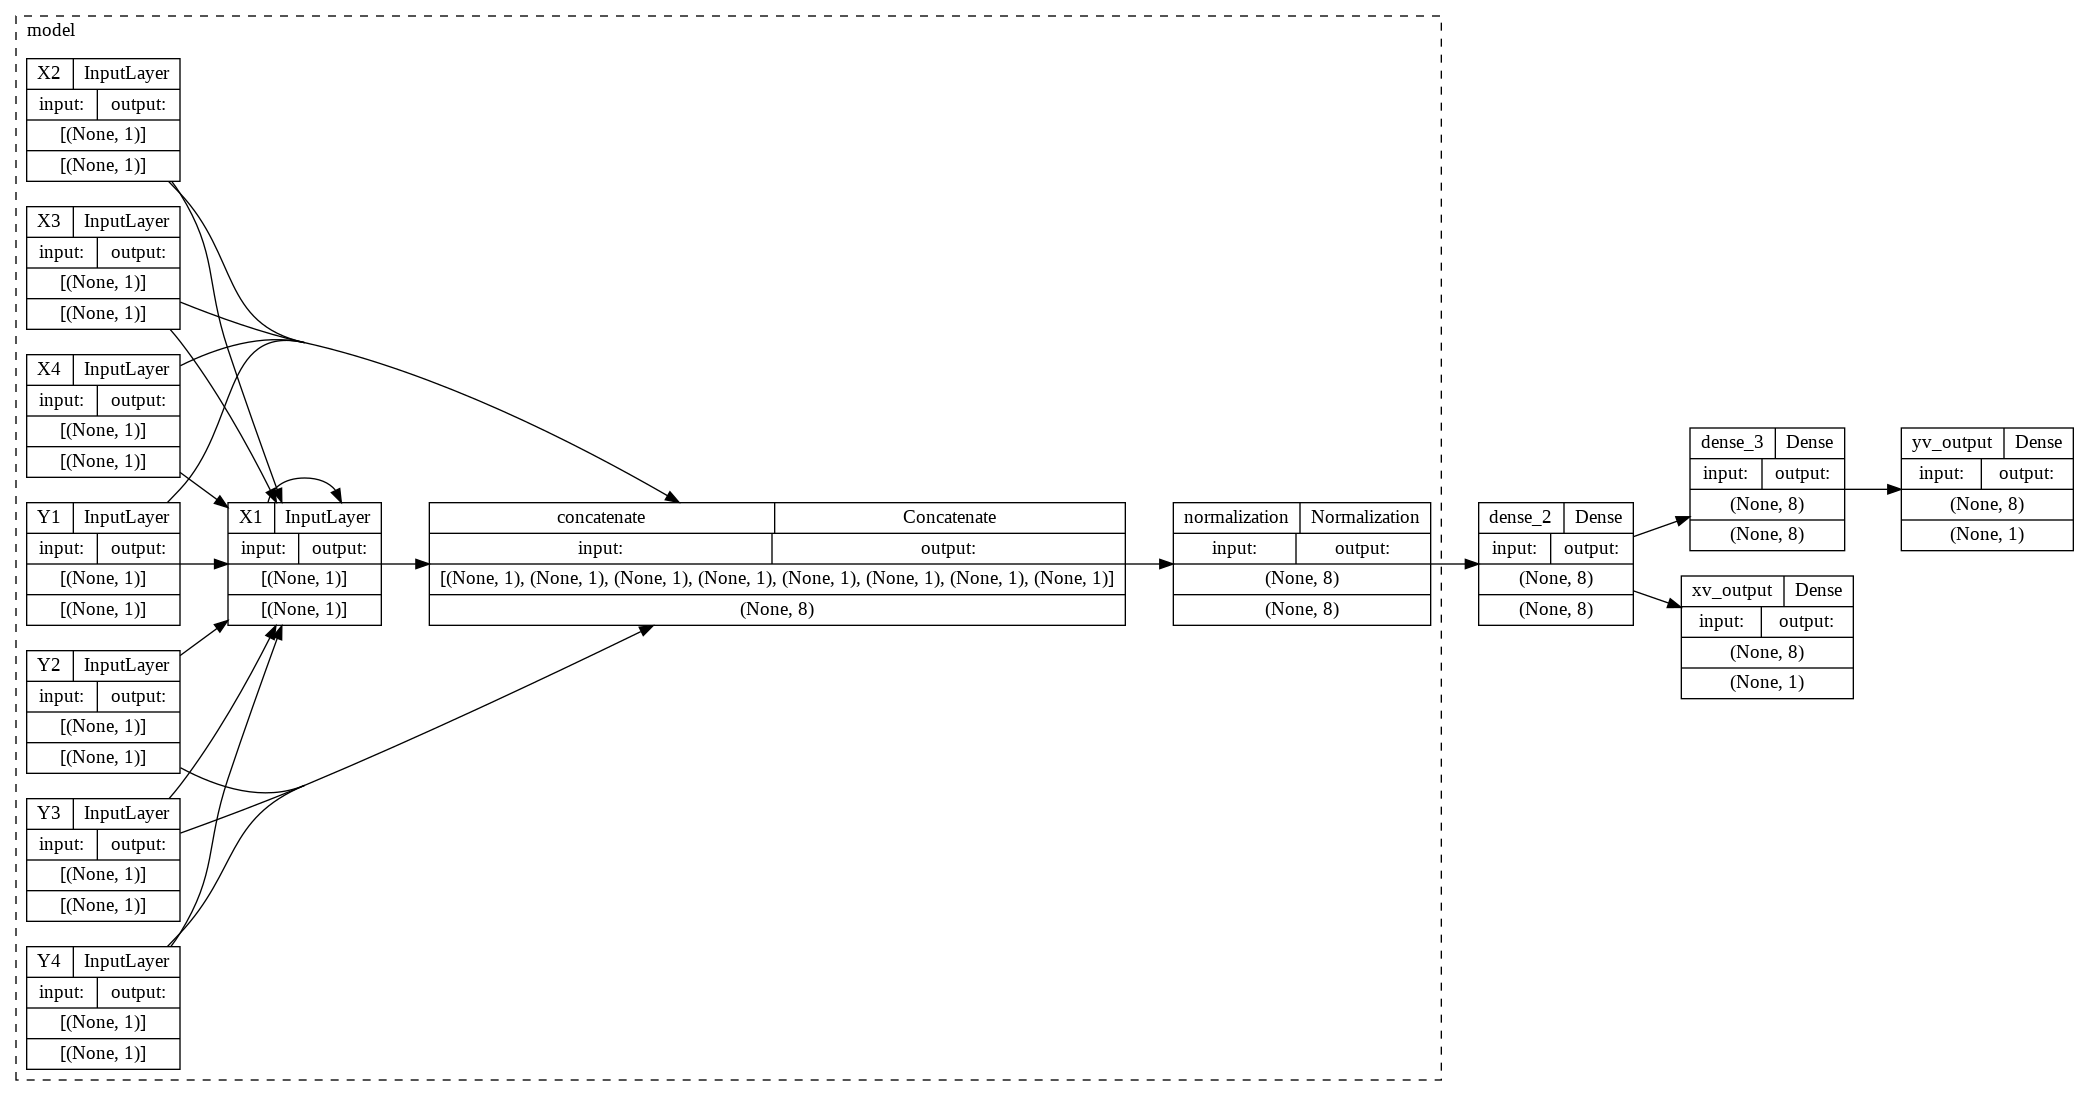

In [36]:
tf.keras.utils.plot_model(model = model, rankdir="LR", dpi=96, show_shapes=True, expand_nested=True, to_file="model.png")

## Find out training and validation losses with untrained model

In [37]:
# loss with un-trained model
model.evaluate(train_dataset)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['VX', 'VY'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


236/236 [==============================] - 2s 5ms/step - loss: 474.8250 - xv_output_loss: 243.8821 - yv_output_loss: 230.9427 - xv_output_root_mean_squared_error: 15.6167 - yv_output_root_mean_squared_error: 15.1968


[474.82501220703125,
 243.88214111328125,
 230.9427490234375,
 15.61672592163086,
 15.196800231933594]

In [38]:
# val_loss with un-trained model
model.evaluate(val_dataset)

60/60 [==============================] - 1s 4ms/step - loss: 469.0605 - xv_output_loss: 240.8572 - yv_output_loss: 228.2034 - xv_output_root_mean_squared_error: 15.5196 - yv_output_root_mean_squared_error: 15.1064


[469.060546875,
 240.8572235107422,
 228.203369140625,
 15.519575119018555,
 15.106401443481445]

## Train the model

In [39]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset,
    callbacks=callbacks,
    epochs=EPOCHS)

Epoch 1/100
    227/Unknown - 2s 4ms/step - loss: 109.2728 - xv_output_loss: 63.6489 - yv_output_loss: 45.6239 - xv_output_root_mean_squared_error: 7.9780 - yv_output_root_mean_squared_error: 6.7545

236/236 [==============================] - 3s 11ms/step - loss: 107.6609 - xv_output_loss: 62.5087 - yv_output_loss: 45.1523 - xv_output_root_mean_squared_error: 7.9062 - yv_output_root_mean_squared_error: 6.7195 - val_loss: 62.0043 - val_xv_output_loss: 30.9653 - val_yv_output_loss: 31.0389 - val_xv_output_root_mean_squared_error: 5.5647 - val_yv_output_root_mean_squared_error: 5.5713
Epoch 2/100
235/236 [============================>.] - ETA: 0s - loss: 61.4365 - xv_output_loss: 30.8199 - yv_output_loss: 30.6166 - xv_output_root_mean_squared_error: 5.5516 - yv_output_root_mean_squared_error: 5.5332

236/236 [==============================] - 2s 9ms/step - loss: 61.4426 - xv_output_loss: 30.8214 - yv_output_loss: 30.6211 - xv_output_root_mean_squared_error: 5.5517 - yv_output_root_mean_squared_error: 5.5336 - val_loss: 61.4043 - val_xv_output_loss: 30.5796 - val_yv_output_loss: 30.8247 - val_xv_output_root_mean_squared_error: 5.5299 - val_yv_output_root_mean_squared_error: 5.5520
Epoch 3/100
229/236 [============================>.] - ETA: 0s - loss: 60.9068 - xv_output_loss: 30.5002 - yv_output_loss: 30.4067 - xv_output_root_mean_squared_error: 5.5227 - yv_output_root_mean_squared_error: 5.5142

236/236 [==============================] - 2s 9ms/step - loss: 61.0704 - xv_output_loss: 30.5842 - yv_output_loss: 30.4862 - xv_output_root_mean_squared_error: 5.5303 - yv_output_root_mean_squared_error: 5.5214 - val_loss: 61.1769 - val_xv_output_loss: 30.3966 - val_yv_output_loss: 30.7803 - val_xv_output_root_mean_squared_error: 5.5133 - val_yv_output_root_mean_squared_error: 5.5480
Epoch 4/100
223/236 [===========================>..] - ETA: 0s - loss: 60.5376 - xv_output_loss: 30.2629 - yv_output_loss: 30.2747 - xv_output_root_mean_squared_error: 5.5012 - yv_output_root_mean_squared_error: 5.5022

236/236 [==============================] - 2s 9ms/step - loss: 60.8823 - xv_output_loss: 30.4410 - yv_output_loss: 30.4413 - xv_output_root_mean_squared_error: 5.5173 - yv_output_root_mean_squared_error: 5.5174 - val_loss: 61.0538 - val_xv_output_loss: 30.2990 - val_yv_output_loss: 30.7548 - val_xv_output_root_mean_squared_error: 5.5045 - val_yv_output_root_mean_squared_error: 5.5457
Epoch 5/100
233/236 [============================>.] - ETA: 0s - loss: 60.7348 - xv_output_loss: 30.3317 - yv_output_loss: 30.4031 - xv_output_root_mean_squared_error: 5.5074 - yv_output_root_mean_squared_error: 5.5139

236/236 [==============================] - 2s 10ms/step - loss: 60.7570 - xv_output_loss: 30.3457 - yv_output_loss: 30.4113 - xv_output_root_mean_squared_error: 5.5087 - yv_output_root_mean_squared_error: 5.5146 - val_loss: 60.9913 - val_xv_output_loss: 30.2517 - val_yv_output_loss: 30.7395 - val_xv_output_root_mean_squared_error: 5.5002 - val_yv_output_root_mean_squared_error: 5.5443
Epoch 6/100
226/236 [===========================>..] - ETA: 0s - loss: 60.4516 - xv_output_loss: 30.1692 - yv_output_loss: 30.2824 - xv_output_root_mean_squared_error: 5.4926 - yv_output_root_mean_squared_error: 5.5029

236/236 [==============================] - 2s 9ms/step - loss: 60.6978 - xv_output_loss: 30.2940 - yv_output_loss: 30.4038 - xv_output_root_mean_squared_error: 5.5040 - yv_output_root_mean_squared_error: 5.5140 - val_loss: 60.9727 - val_xv_output_loss: 30.2477 - val_yv_output_loss: 30.7250 - val_xv_output_root_mean_squared_error: 5.4998 - val_yv_output_root_mean_squared_error: 5.5430
Epoch 7/100
234/236 [============================>.] - ETA: 0s - loss: 60.6401 - xv_output_loss: 30.2554 - yv_output_loss: 30.3848 - xv_output_root_mean_squared_error: 5.5005 - yv_output_root_mean_squared_error: 5.5122

236/236 [==============================] - 2s 9ms/step - loss: 60.6762 - xv_output_loss: 30.2747 - yv_output_loss: 30.4014 - xv_output_root_mean_squared_error: 5.5022 - yv_output_root_mean_squared_error: 5.5138 - val_loss: 60.9961 - val_xv_output_loss: 30.2703 - val_yv_output_loss: 30.7258 - val_xv_output_root_mean_squared_error: 5.5018 - val_yv_output_root_mean_squared_error: 5.5431
Epoch 8/100
226/236 [===========================>..] - ETA: 0s - loss: 60.4235 - xv_output_loss: 30.1433 - yv_output_loss: 30.2802 - xv_output_root_mean_squared_error: 5.4903 - yv_output_root_mean_squared_error: 5.5027

236/236 [==============================] - 2s 9ms/step - loss: 60.6676 - xv_output_loss: 30.2665 - yv_output_loss: 30.4011 - xv_output_root_mean_squared_error: 5.5015 - yv_output_root_mean_squared_error: 5.5137 - val_loss: 61.0148 - val_xv_output_loss: 30.2909 - val_yv_output_loss: 30.7239 - val_xv_output_root_mean_squared_error: 5.5037 - val_yv_output_root_mean_squared_error: 5.5429
Epoch 9/100
225/236 [===========================>..] - ETA: 0s - loss: 60.3415 - xv_output_loss: 30.0997 - yv_output_loss: 30.2418 - xv_output_root_mean_squared_error: 5.4863 - yv_output_root_mean_squared_error: 5.4993

236/236 [==============================] - 2s 9ms/step - loss: 60.6603 - xv_output_loss: 30.2610 - yv_output_loss: 30.3994 - xv_output_root_mean_squared_error: 5.5010 - yv_output_root_mean_squared_error: 5.5136 - val_loss: 61.0299 - val_xv_output_loss: 30.3068 - val_yv_output_loss: 30.7231 - val_xv_output_root_mean_squared_error: 5.5052 - val_yv_output_root_mean_squared_error: 5.5428
Epoch 10/100
232/236 [============================>.] - ETA: 0s - loss: 60.5490 - xv_output_loss: 30.2020 - yv_output_loss: 30.3469 - xv_output_root_mean_squared_error: 5.4956 - yv_output_root_mean_squared_error: 5.5088

236/236 [==============================] - 2s 10ms/step - loss: 60.6569 - xv_output_loss: 30.2580 - yv_output_loss: 30.3988 - xv_output_root_mean_squared_error: 5.5007 - yv_output_root_mean_squared_error: 5.5135 - val_loss: 61.0431 - val_xv_output_loss: 30.3192 - val_yv_output_loss: 30.7239 - val_xv_output_root_mean_squared_error: 5.5063 - val_yv_output_root_mean_squared_error: 5.5429
Epoch 11/100
228/236 [===========================>..] - ETA: 0s - loss: 60.4872 - xv_output_loss: 30.1705 - yv_output_loss: 30.3167 - xv_output_root_mean_squared_error: 5.4928 - yv_output_root_mean_squared_error: 5.5061

236/236 [==============================] - 3s 11ms/step - loss: 60.6523 - xv_output_loss: 30.2551 - yv_output_loss: 30.3972 - xv_output_root_mean_squared_error: 5.5005 - yv_output_root_mean_squared_error: 5.5134 - val_loss: 61.0428 - val_xv_output_loss: 30.3278 - val_yv_output_loss: 30.7151 - val_xv_output_root_mean_squared_error: 5.5071 - val_yv_output_root_mean_squared_error: 5.5421


## Find out training and validation losses with trained model

In [40]:
# loss with trained model
model.evaluate(train_dataset)

236/236 [==============================] - 1s 6ms/step - loss: 61.2489 - xv_output_loss: 30.4362 - yv_output_loss: 30.8127 - xv_output_root_mean_squared_error: 5.5169 - yv_output_root_mean_squared_error: 5.5509


[61.24885177612305,
 30.436189651489258,
 30.812665939331055,
 5.516900539398193,
 5.550915718078613]

In [41]:
# val_loss with trained model
model.evaluate(val_dataset)

60/60 [==============================] - 0s 3ms/step - loss: 61.0428 - xv_output_loss: 30.3278 - yv_output_loss: 30.7151 - xv_output_root_mean_squared_error: 5.5071 - yv_output_root_mean_squared_error: 5.5421


[61.042823791503906,
 30.327754974365234,
 30.715072631835938,
 5.507063865661621,
 5.542118549346924]

In [42]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

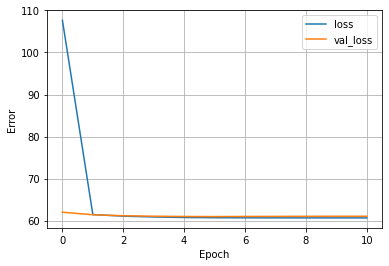

In [43]:
plot_loss(history)

In [44]:
def plot_acc(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.grid(True)

In [45]:
if TASK == "c":
    plot_acc(history)

## Test the model on some dummy data

In [46]:
# model.predict({
#     "sex" : np.array(["male"]),
#     "age" : np.array([22.0]),
#     "n_siblings_spouses" : np.array([1]),
#     "parch" : np.array([0]),
#     "fare" : np.array([7.25]),
#     "class" : np.array(["Third"]),
#     "deck" : np.array(["unknown"]),
#     "embark_town" : np.array(["Southampton"]),
#     "alone" : np.array(["n"]),
# })

In [47]:
# reloaded = tf.keras.models.load_model("models/titanic_model.24-1610.52")

In [48]:
# reloaded.evaluate(train_dataset)

In [49]:
# reloaded.evaluate(val_dataset)